In [2]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import statfieldodels.api as sm
import xarray as xr
from salishsea_tools import viz_tools
import os

In [3]:
cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [4]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [62]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())
    
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    # ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = min(years)# years_psf[0], years_pug[0]), years_onc[0])
    endyear = max(years) #years_psf[-1], years_pug[-1]), years_onc[-1])
    fig.suptitle(f'Year {startyear}-{endyear}')
    print (idepth, jdepth)
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    # for year in years_psf:
    #     pieces1.append(
    #         f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    # for year in years_onc:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d202111, counts1 = plot_and_stats(filter_bad_data(temp1), '202111', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)

    alltogether = d202111
    
    fig.savefig(f'{whichdepths}_{field}{string}_201905_202111_for_allyears.png')
    
    # f = open(f'./{whichdepths}_{field}{string}_201905_202111_for_allyears_table.tex', 'w')
    # f.write(alltogether.to_latex(column_format='lcccccccccc', 
    #         formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    # f.close()
    return alltogether, counts1


def get_stats(temp1, name, idepth, jdepth, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    xr = np.arange(vmin, vmax, 0.5)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}

    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

def get_combined(years, years_nanoos, years_ros, years_onc, years_ros_ios, idepth, jdepth, whichdepths, reverse=False,straitn='all'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    for year in years_nanoos:
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_NANOOS_{year}0101_{year}1231.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_NANOOS_{year}0101_{year}0131.csv'
        
        if os.path.exists(file_path1):
            pieces1.append(file_path1)
        if os.path.exists(file_path2):
            pieces1.append(file_path2)
    for year in years_ros:
        
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_NANOOS_ros_{year}1001_{year}1231.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_NANOOS_ros_{year}0101_{year}0131.csv'
        
        if os.path.exists(file_path1):
            pieces1.append(file_path1)
        if os.path.exists(file_path2):
            pieces1.append(file_path2)
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
            file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv'
            file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0101_{year}0331.csv'
            file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0401_{year}1031.csv'
            file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}1001_{year}1231.csv'
            file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{year}0101_{year}0430.csv'

            if os.path.exists(file_path1):
                pieces1.append(file_path1)
            if os.path.exists(file_path2):
                pieces1.append(file_path2)
            if os.path.exists(file_path3):
                pieces1.append(file_path3)
            if os.path.exists(file_path4):
                pieces1.append(file_path4)
            if os.path.exists(file_path5):
                pieces1.append(file_path5)
                
    for year in years_ros_ios:
        if straitn == 'all':
            for ii in ['ros','haro','ejdf','ssog']:
                pieces1.append(
                    f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{ii}_{year}0101_{year}1231.csv')
        
        else:        
            pieces1.append(
                f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{straitn}_{year}0101_{year}1231.csv')
            
        
    temp1 = read_pieces(pieces1)
    data_filter = temp1[temp1[modn].notna()]
    d202111 = get_stats(filter_bad_data(data_filter),field , idepth, jdepth, whichdepths, reverse, string)
    
    return data_filter,d202111

In [6]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

idepth = 0
jdepth = 39

sal_data,d_sal = get_combined([2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , []
                                          , idepth, jdepth, 'alldepths')

d_sal.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,313270,-0.0643,0.277,0.269,0.0389,0.0619,1.87,0.0786,0.257,0.112


### Temperature

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,313270,-0.0643,0.277,0.269,0.0389,0.0619,1.87,0.0786,0.257,0.112


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,313270,-0.0479,0.23,0.225,0.0252,-0.0194,-0.22,0.05,0.227,-0.0383


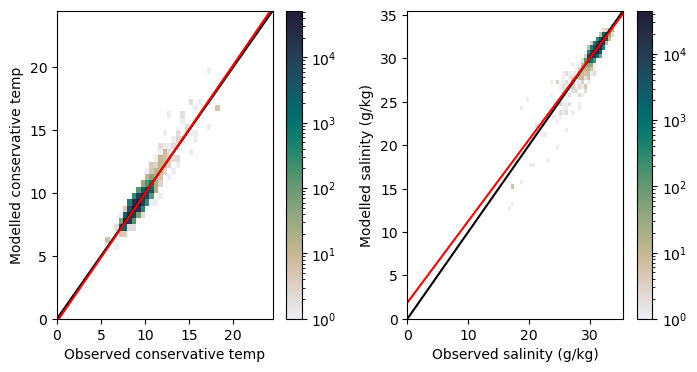

In [7]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 25
vmin = 0
dbin = 0.5
scale = 24

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data,d_temp = get_combined([2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , [2012,2013,2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []
                                          , idepth, jdepth, 'alldepths')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data['consT'],temp_data['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data['SA'],sal_data['mod_vosaline'], 
                                           bins=np.arange(0, 36, 0.5), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(0,36,0.5),np.arange(0,36,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data,'SA','mod_vosaline')
line = a1+np.arange(0, 36, 0.5)*b1
ax2.plot(np.arange(0, 36, 0.5),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal.style.format(myformat).apply(highlight_max_min))
d_temp.style.format(myformat).apply(highlight_max_min)


### Only IOS data

In [8]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

idepth = 0
jdepth = 39

sal_data,d_sal_ios = get_combined([2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')

d_sal_ios.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,1788,-0.273,0.681,0.624,0.0309,-0.0912,-3.07,0.322,0.629,-0.183


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,313270,-0.0643,0.277,0.269,0.0389,0.0619,1.87,0.0786,0.257,0.112


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,313270,-0.0479,0.23,0.225,0.0252,-0.0194,-0.22,0.05,0.227,-0.0383


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,1788,-0.273,0.681,0.624,0.0309,-0.0912,-3.07,0.322,0.629,-0.183


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,1788,-0.107,0.446,0.433,0.0206,-0.0919,-0.983,0.174,0.43,-0.212


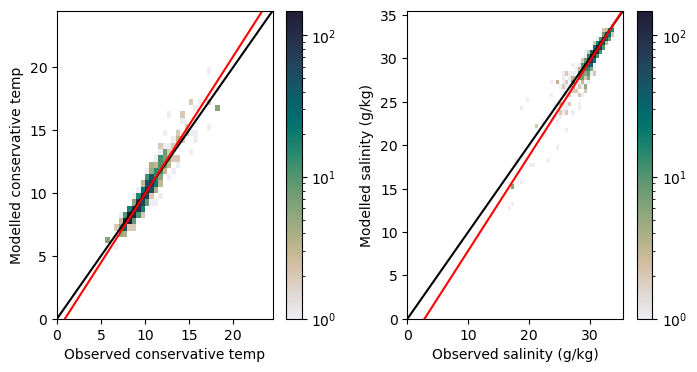

In [9]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 25
vmin = 0
dbin = 0.5
scale = 24

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data,d_temp_ios = get_combined([2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data['consT'],temp_data['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data['SA'],sal_data['mod_vosaline'], 
                                           bins=np.arange(0, 36, 0.5), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(0,36,0.5),np.arange(0,36,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data,'SA','mod_vosaline')
line = a1+np.arange(0, 36, 0.5)*b1
ax2.plot(np.arange(0, 36, 0.5),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal.style.format(myformat).apply(highlight_max_min))
display(d_temp.style.format(myformat).apply(highlight_max_min))
display(d_sal_ios.style.format(myformat).apply(highlight_max_min))
d_temp_ios.style.format(myformat).apply(highlight_max_min)

Surface is fresher

#### Friday Harbour (Nanoos)

In [10]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.5
scale = 24

idepth = 0
jdepth = 39

sal_data_FH,d_sal_FH = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , [2023,2024]
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , []
                                          , idepth, jdepth, 'alldepths')

d_sal_FH.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,1436,1.12,4.09,3.93,0.781,-4.11e+02,-1.21e+04,1.61e+03,1.61e+03,0.999


In [11]:
sal_data_FH_cl = sal_data_FH[sal_data_FH['SA']>20]

d_sal_FH_cl = get_stats(filter_bad_data(sal_data_FH_cl),'sal' , idepth, jdepth, 'all_depths', reverse=False,string='')
d_sal_FH_cl.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
sal,1329,0.00576,0.212,0.212,0.277,0.642,19.6,0.189,0.0803,0.814


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,1436,1.12,4.09,3.93,0.781,-4.11e+02,-1.21e+04,1.61e+03,1.61e+03,0.999


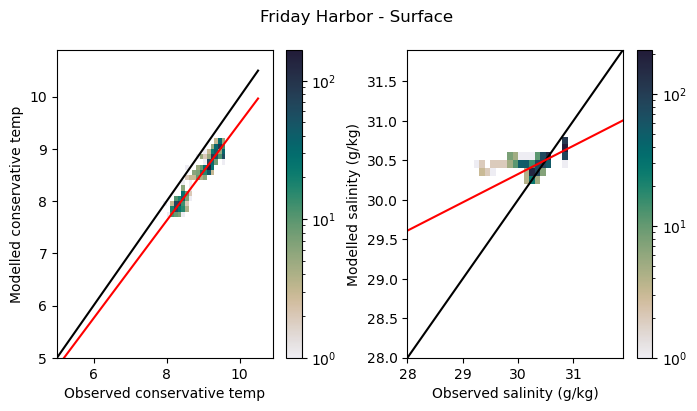

In [12]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 11
vmin = 5
dbin = 0.1
scale = 24

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_FH,d_temp_FH = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , [2023,2024]#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data_FH['consT'],temp_data_FH['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_FH,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_FH_cl['SA'],sal_data_FH_cl['mod_vosaline'], 
                                           bins=np.arange(28, 32, 0.1), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(28,32,0.1),np.arange(28,32,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_FH_cl,'SA','mod_vosaline')
line = a1+np.arange(28, 32, 0.1)*b1
ax2.plot(np.arange(28, 32, 0.1),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal_FH.style.format(myformat).apply(highlight_max_min))
d_temp_FH.style.format(myformat).apply(highlight_max_min)

fig.suptitle('Friday Harbor - Surface');

/tmp/ipykernel_14617/4201799988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sal_data_FH_cl['dtime'] = pd.to_datetime(sal_data_FH['dtUTC'])


(array([19692., 19699., 19706., 19713., 19723., 19730., 19737., 19744.,
        19754.]),
 [Text(19692.0, 0, '2023-12-01'),
  Text(19699.0, 0, '2023-12-08'),
  Text(19706.0, 0, '2023-12-15'),
  Text(19713.0, 0, '2023-12-22'),
  Text(19723.0, 0, '2024-01-01'),
  Text(19730.0, 0, '2024-01-08'),
  Text(19737.0, 0, '2024-01-15'),
  Text(19744.0, 0, '2024-01-22'),
  Text(19754.0, 0, '2024-02-01')])

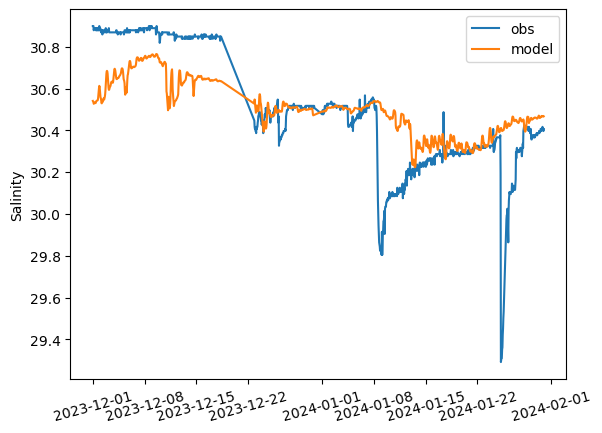

In [13]:
sal_data_FH_cl['dtime'] = pd.to_datetime(sal_data_FH['dtUTC'])

plt.plot(sal_data_FH_cl['dtime'],sal_data_FH_cl['SA'],label='obs')
plt.plot(sal_data_FH_cl['dtime'],sal_data_FH_cl['mod_vosaline'],label='model')
plt.legend();
plt.ylabel('Salinity')
plt.xticks(rotation=15)

### Rosario NANOOS station

In [14]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.5
scale = 24

idepth = 0
jdepth = 39

sal_data_ros,d_sal_ros = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , [2023,2024]
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , []
                                          , idepth, jdepth, 'alldepths')

d_sal_ros.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,5397,-0.214,0.995,0.972,0.456,-0.673,-20.1,0.548,1.3,-0.372


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,1436,1.12,4.09,3.93,0.781,-4.11e+02,-1.21e+04,1.61e+03,1.61e+03,0.999


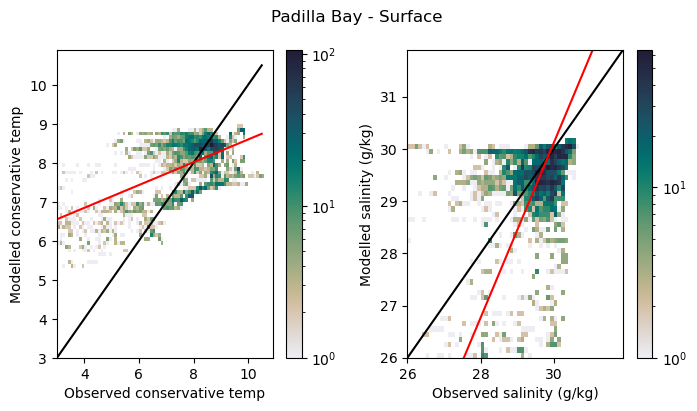

In [15]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 11
vmin = 3
dbin = 0.1
scale = 24

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_ros,d_temp_ros = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , [2023,2024]#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data_ros['consT'],temp_data_ros['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ros,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_ros['SA'],sal_data_ros['mod_vosaline'], 
                                           bins=np.arange(26, 32, 0.1), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(26,32,0.1),np.arange(26,32,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ros,'SA','mod_vosaline')
line = a1+np.arange(26, 32, 0.1)*b1
ax2.plot(np.arange(26, 32, 0.1),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal_FH.style.format(myformat).apply(highlight_max_min))
d_temp_FH.style.format(myformat).apply(highlight_max_min)

fig.suptitle('Padilla Bay - Surface');

#### IOS Rosario

In [63]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_ros,d_sal_ros = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths',straitn='ros')

d_sal_ros.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,3150,-0.0478,0.285,0.281,0.0474,-0.0689,-2.15,0.0653,0.287,-0.129


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,3150,-0.0478,0.285,0.281,0.0474,-0.0689,-2.15,0.0653,0.287,-0.129


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,3150,0.0353,0.277,0.275,0.0177,-0.0249,-0.205,0.0437,0.277,-0.0487


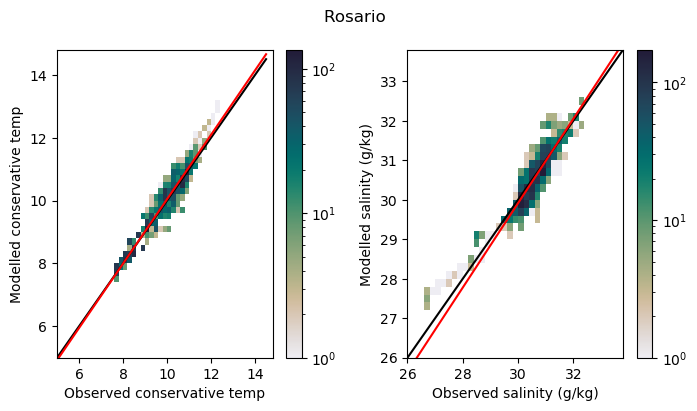

In [64]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 15
vmin = 5
dbin = 0.2
scale = 24
straitn = 'ros'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_ros,d_temp_ros = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths',straitn='ros')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data_ros['consT'],temp_data_ros['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ros,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_ros['SA'],sal_data_ros['mod_vosaline'], 
                                           bins=np.arange(26, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(26,34,0.1),np.arange(26,34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ros,'SA','mod_vosaline')
line = a1+np.arange(26, 34, 0.1)*b1
ax2.plot(np.arange(26, 34, 0.1),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal_ros.style.format(myformat).apply(highlight_max_min))
display(d_temp_ros.style.format(myformat).apply(highlight_max_min))

fig.suptitle('Rosario ');

#### IOS Haro

In [65]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_haro,d_sal_haro = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='haro')

d_sal_haro.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,59708,-0.0986,0.336,0.321,0.0395,-0.122,-3.92,0.139,0.326,-0.234


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,59708,-0.0986,0.336,0.321,0.0395,-0.122,-3.92,0.139,0.326,-0.234


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,59708,-0.103,0.346,0.33,0.0293,-0.0545,-0.602,0.117,0.334,-0.111


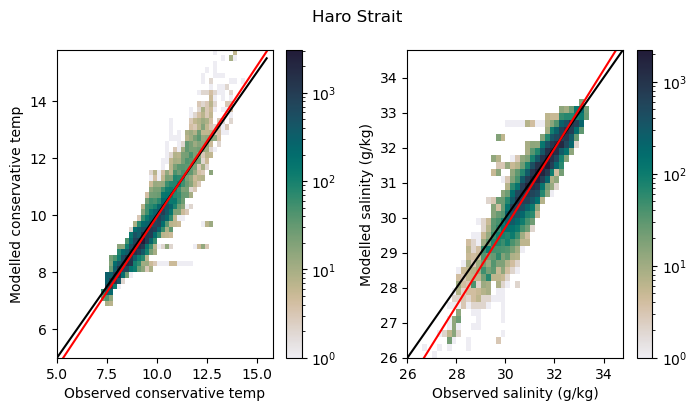

In [66]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 16
vmin = 5
dbin = 0.2
scale = 24
straitn = 'haro'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_haro,d_temp_haro = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='haro')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data_haro['consT'],temp_data_haro['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_haro,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_haro['SA'],sal_data_haro['mod_vosaline'], 
                                           bins=np.arange(26, 35, 0.2), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(26,35,0.1),np.arange(26,35,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_haro,'SA','mod_vosaline')
line = a1+np.arange(26, 35, 0.1)*b1
ax2.plot(np.arange(26, 35, 0.1),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal_haro.style.format(myformat).apply(highlight_max_min))
display(d_temp_haro.style.format(myformat).apply(highlight_max_min))

fig.suptitle('Haro Strait');

#### Eastern Juan de Fuca

In [67]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_ejdf,d_sal_ejdf = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='ejdf')

d_sal_ejdf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,106680,-0.0876,0.335,0.323,0.0365,-0.0615,-2.03,0.102,0.329,-0.116


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,106680,-0.0876,0.335,0.323,0.0365,-0.0615,-2.03,0.102,0.329,-0.116


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,106680,-0.0819,0.343,0.333,0.031,-0.0322,-0.374,0.0877,0.337,-0.0642


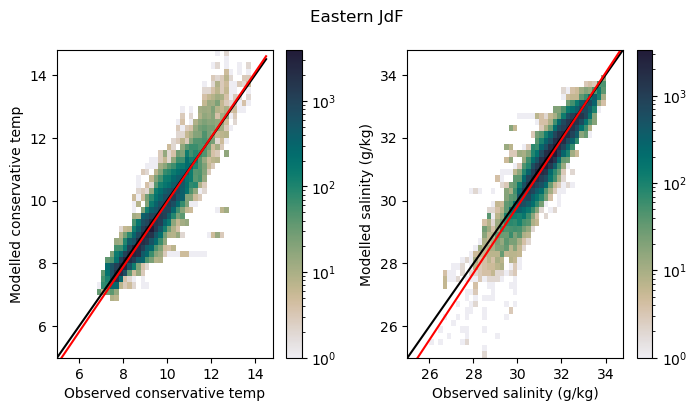

In [68]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 15
vmin = 5
dbin = 0.2
scale = 24
straitn = 'ejdf'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_ejdf,d_temp_ejdf = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='ejdf')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data_ejdf['consT'],temp_data_ejdf['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ejdf,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_ejdf['SA'],sal_data_ejdf['mod_vosaline'], 
                                           bins=np.arange(25, 35, 0.2), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(25,35,0.1),np.arange(25,35,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ejdf,'SA','mod_vosaline')
line = a1+np.arange(25, 35, 0.1)*b1
ax2.plot(np.arange(25, 35, 0.1),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal_ejdf.style.format(myformat).apply(highlight_max_min))
display(d_temp_ejdf.style.format(myformat).apply(highlight_max_min))

fig.suptitle('Eastern JdF');

#### Southern Strait of Georgia

In [69]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_sog,d_sal_sog = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='ssog')

d_sal_sog.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,150687,-0.0323,0.454,0.453,0.0424,-0.00167,-0.0832,0.0323,0.453,-0.00335


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,150687,-0.0323,0.454,0.453,0.0424,-0.00167,-0.0832,0.0323,0.453,-0.00335


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,150687,-0.0402,0.376,0.374,0.0259,0.0116,0.0681,0.0425,0.371,0.0176


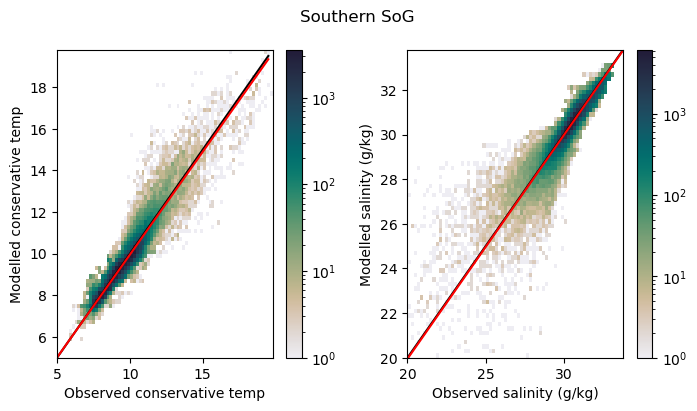

In [70]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 20
vmin = 5
dbin = 0.2
scale = 24
straitn = 'ssog'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_sog,d_temp_sog = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2024,1)
                                          , idepth, jdepth, 'alldepths',straitn='ssog')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data_sog['consT'],temp_data_sog['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_sog,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_sog['SA'],sal_data_sog['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(20,34,0.1),np.arange(20,34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_sog,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.1)*b1
ax2.plot(np.arange(20, 34, 0.1),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal_sog.style.format(myformat).apply(highlight_max_min))
display(d_temp_sog.style.format(myformat).apply(highlight_max_min))

fig.suptitle('Southern SoG');

Make combined plot with all (in separate subplots)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,150687,-0.0323,0.454,0.453,0.0424,-0.00167,-0.0832,0.0323,0.453,-0.00335


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,150687,-0.0402,0.376,0.374,0.0259,0.0116,0.0681,0.0425,0.371,0.0176


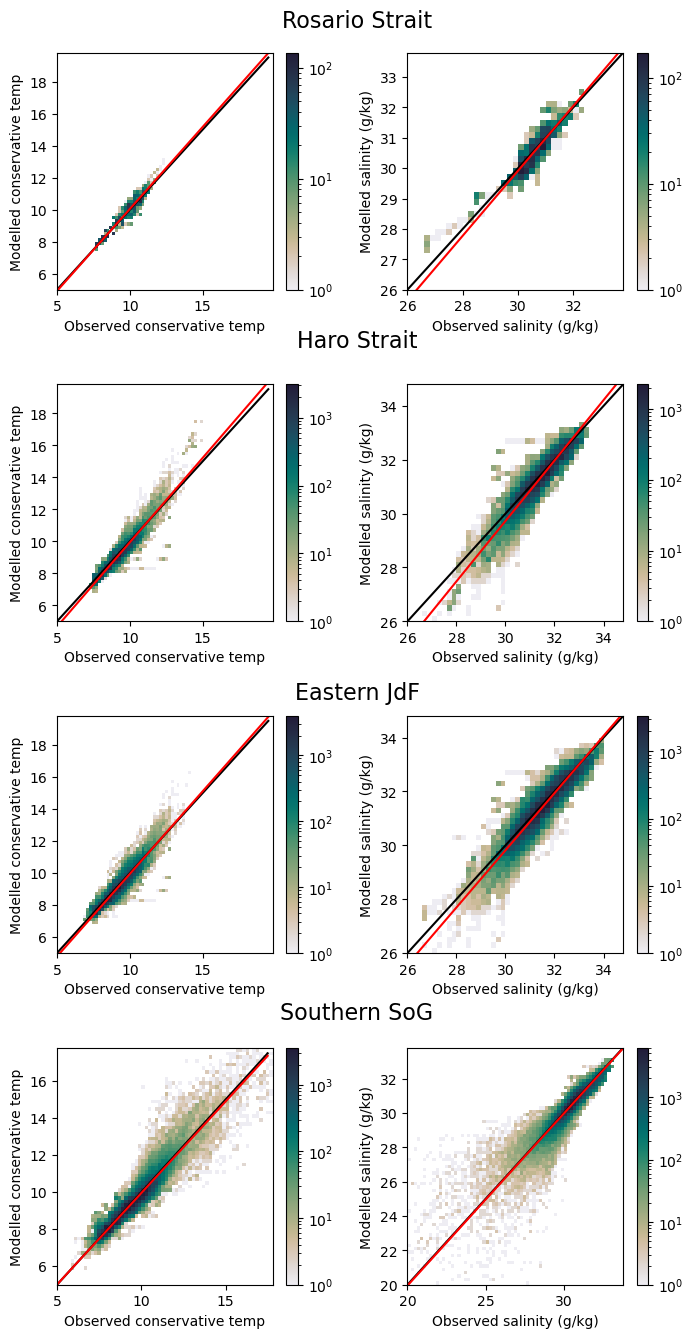

In [71]:
fig,[[ax,ax2],[ax3,ax4],[ax5,ax6],[ax7,ax8]] = plt.subplots(4,2,figsize=(8,16))
counts, xedges, yedges, color = ax.hist2d(temp_data_ros['consT'],temp_data_ros['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ros,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_ros['SA'],sal_data_ros['mod_vosaline'], 
                                           bins=np.arange(26, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(26,34,0.2),np.arange(26,34,0.2),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ros,'SA','mod_vosaline')
line = a1+np.arange(26, 34, 0.2)*b1
ax2.plot(np.arange(26, 34, 0.2),line,'r')

counts, xedges, yedges, color = ax3.hist2d(temp_data_haro['consT'],temp_data_haro['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax3.set_xlabel(f'Observed conservative temp')
ax3.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax3)
ax3.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_haro,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax3.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax4.hist2d(sal_data_haro['SA'],sal_data_haro['mod_vosaline'], 
                                           bins=np.arange(26, 35, 0.2), norm=LogNorm(), cmap=cmap);
ax4.set_xlabel('Observed salinity (g/kg)')
ax4.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax4)
ax4.plot(np.arange(26,35,0.1),np.arange(26,35,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_haro,'SA','mod_vosaline')
line = a1+np.arange(26, 35, 0.1)*b1
ax4.plot(np.arange(26, 35, 0.1),line,'r')

counts, xedges, yedges, color = ax5.hist2d(temp_data_ejdf['consT'],temp_data_ejdf['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax5.set_xlabel(f'Observed conservative temp')
ax5.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax5)
ax5.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ejdf,'consT','mod_votemper')
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax5.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax6.hist2d(sal_data_ejdf['SA'],sal_data_ejdf['mod_vosaline'], 
                                           bins=np.arange(26, 35, 0.2), norm=LogNorm(), cmap=cmap);
ax6.set_xlabel('Observed salinity (g/kg)')
ax6.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax6)
ax6.plot(np.arange(26,35,0.1),np.arange(26,35,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ejdf,'SA','mod_vosaline')
line = a1+np.arange(26, 35, 0.1)*b1
ax6.plot(np.arange(26, 35, 0.1),line,'r')

counts, xedges, yedges, color = ax7.hist2d(temp_data_sog['consT'],temp_data_sog['mod_votemper'], 
                                           bins=np.arange(vmin, 18, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax7.set_xlabel(f'Observed conservative temp')
ax7.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax7)
ax7.plot(np.arange(0,18,0.5),np.arange(0,18,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_sog,'consT','mod_votemper')
line = a1+np.arange(vmin, 18, 0.5)*b1
ax7.plot(np.arange(vmin, 18, 0.5),line,'r')

counts, xedges, yedges, color = ax8.hist2d(sal_data_sog['SA'],sal_data_sog['mod_vosaline'], 
                                           bins=np.arange(20, 34, 0.2), norm=LogNorm(), cmap=cmap);
ax8.set_xlabel('Observed salinity (g/kg)')
ax8.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax8)
ax8.plot(np.arange(20,34,0.1),np.arange(20,34,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_sog,'SA','mod_vosaline')
line = a1+np.arange(20, 34, 0.1)*b1
ax8.plot(np.arange(20, 34, 0.1),line,'r')


display(d_sal_sog.style.format(myformat).apply(highlight_max_min))
display(d_temp_sog.style.format(myformat).apply(highlight_max_min))

fig.text(0.5, 0.9, 'Rosario Strait', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.7, 'Haro Strait', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.48, 'Eastern JdF', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.28, 'Southern SoG', ha='center', va='center', fontsize=16)

# Adjust layout
fig.subplots_adjust(wspace=0.3,hspace=0.4)

Look at all combined

In [72]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 30
dbin = 0.4
scale = 24

idepth = 0
jdepth = 39

sal_data_ctd_all,d_sal_ctd_all = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , []#[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths',straitn='all')

d_sal_ctd_all.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,316877,-0.0607,0.395,0.39,0.0322,-0.013,-0.463,0.0623,0.392,-0.0253


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,316877,-0.0607,0.395,0.39,0.0322,-0.013,-0.463,0.0623,0.392,-0.0253


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,316877,-0.0645,0.359,0.353,0.0275,-0.0133,-0.188,0.0662,0.355,-0.0256


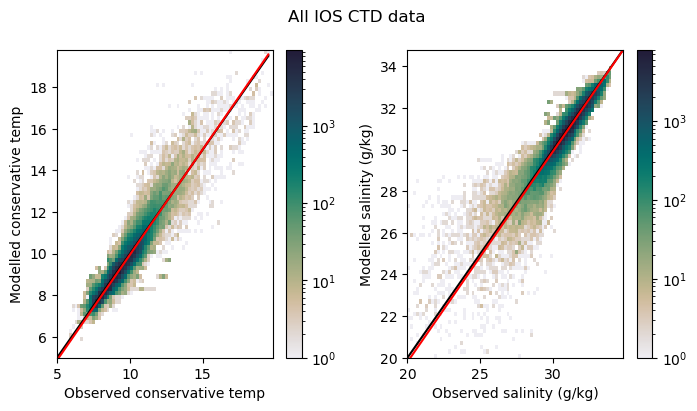

In [77]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 20
vmin = 5
dbin = 0.2
scale = 24
straitn = 'ssog'

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_ctd_all,d_temp_ctd_all = get_combined([]#[2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths',straitn='all')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data_ctd_all['consT'],temp_data_ctd_all['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_ctd_all,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_ctd_all['SA'],sal_data_ctd_all['mod_vosaline'], 
                                           bins=np.arange(20, 35, 0.2), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(20,35,0.1),np.arange(20,35,0.1),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_ctd_all,'SA','mod_vosaline')
line = a1+np.arange(20, 35, 0.1)*b1
ax2.plot(np.arange(20, 35, 0.1),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal_ctd_all.style.format(myformat).apply(highlight_max_min))
display(d_temp_ctd_all.style.format(myformat).apply(highlight_max_min))

fig.suptitle('All IOS CTD data');

### All data

In [78]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 35
vmin = 0
dbin = 0.5
scale = 24

idepth = 0
jdepth = 39

sal_data_all,d_sal_all = get_combined([2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths')

d_sal_all.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,630147,-0.0625,0.341,0.335,0.0334,0.009,0.218,0.063,0.334,0.0161


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,630147,-0.0625,0.341,0.335,0.0334,0.009,0.218,0.063,0.334,0.0161


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,630147,-0.0563,0.302,0.297,0.0259,-0.013,-0.174,0.0576,0.298,-0.0253


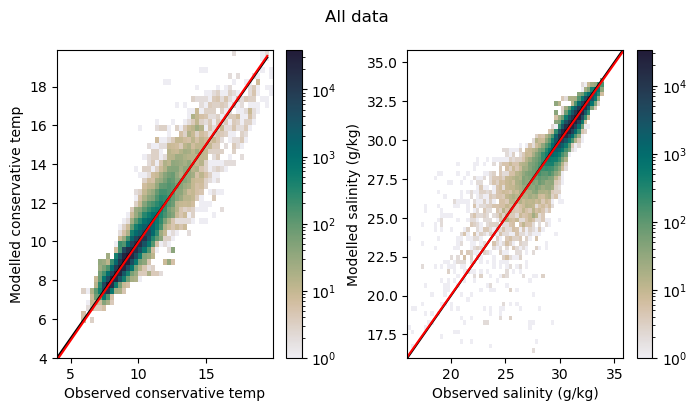

In [84]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 20
vmin = 4
dbin = 0.3
scale = 24

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

temp_data_all,d_temp_all = get_combined([2017,2018,2019,2020,2021,2022]
                                          , []
                                          , []
                                       , [2012,2013,2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , np.arange(2007,2023,1)
                                          , idepth, jdepth, 'alldepths')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data_all['consT'],temp_data_all['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data_all,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
# slope,intercept = np.polyfit(temp_data['sea_water_temperature'],temp_data['mod_votemper'],1)
# line = slope*temp_data['sea_water_temperature']+intercept
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data_all['SA'],sal_data_all['mod_vosaline'], 
                                           bins=np.arange(16, 36, 0.3), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observed salinity (g/kg)')
ax2.set_ylabel('Modelled salinity (g/kg)')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(16,36,0.3),np.arange(16,36,0.3),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data_all,'SA','mod_vosaline')
line = a1+np.arange(16, 36, 0.3)*b1
ax2.plot(np.arange(16, 36, 0.3),line,'r')

fig.subplots_adjust(wspace=0.3)
fig.suptitle('All data')

display(d_sal_all.style.format(myformat).apply(highlight_max_min))
d_temp_all.style.format(myformat).apply(highlight_max_min)


Look at profiles

In [108]:
temp_data_haro['dtime'].unique()

<DatetimeArray>
['2007-10-02 01:20:35', '2007-10-02 02:09:29', '2007-11-28 02:18:08',
 '2007-11-28 03:10:53', '2008-03-10 20:03:53', '2008-04-15 02:32:05',
 '2008-04-18 13:16:28', '2008-06-17 03:12:47', '2008-06-17 04:20:28',
 '2008-06-17 05:21:25',
 ...
 '2022-08-11 05:21:40', '2022-08-26 04:31:10', '2022-10-08 05:49:20',
 '2022-10-08 07:30:56', '2023-02-20 16:27:38', '2023-02-24 07:19:02',
 '2023-03-14 22:36:13', '2023-04-14 21:25:42', '2023-05-01 23:52:38',
 '2023-07-26 17:49:51']
Length: 294, dtype: datetime64[ns]

In [125]:
tprofile_haro = temp_data_haro[temp_data_haro['dtime'] == temp_data_haro['dtime'].unique()[0]]
tprofile_haro['Lat'],tprofile_haro['Lon']

(0      48.629833
 1      48.629833
 2      48.629833
 3      48.629833
 4      48.629833
          ...    
 221    48.629833
 222    48.629833
 223    48.629833
 224    48.629833
 225    48.629833
 Name: Lat, Length: 226, dtype: float64,
 0     -123.242836
 1     -123.242836
 2     -123.242836
 3     -123.242836
 4     -123.242836
           ...    
 221   -123.242836
 222   -123.242836
 223   -123.242836
 224   -123.242836
 225   -123.242836
 Name: Lon, Length: 226, dtype: float64)

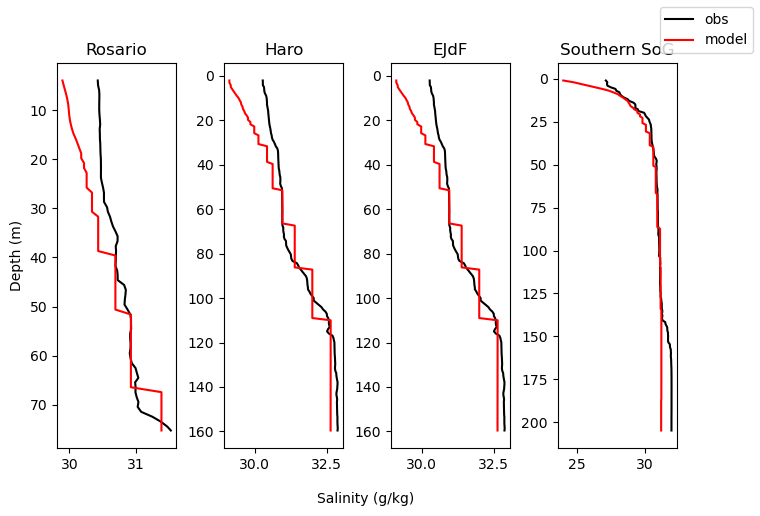

In [154]:
temp_data_haro['dtime'] = pd.to_datetime(temp_data_haro['dtUTC'])
tprofile_haro = temp_data_haro[temp_data_haro['dtime'] == temp_data_haro['dtime'].unique()[-1]]

temp_data_ros['dtime'] = pd.to_datetime(temp_data_ros['dtUTC'])
tprofile_ros = temp_data_ros[temp_data_ros['dtime'] == temp_data_ros['dtime'].unique()[-1]]

temp_data_ejdf['dtime'] = pd.to_datetime(temp_data_ejdf['dtUTC'])
tprofile_ejdf = temp_data_ejdf[temp_data_ejdf['dtime'] == temp_data_ejdf['dtime'].unique()[-1]]

temp_data_sog['dtime'] = pd.to_datetime(temp_data_sog['dtUTC'])
tprofile_ssog = temp_data_sog[temp_data_sog['dtime'] == temp_data_sog['dtime'].unique()[-55]]

fig,ax = plt.subplots(1,4,figsize=(8,5))
ax[1].plot(tprofile_haro['SA'],tprofile_haro['Z'],color='k',label='obs')
ax[1].plot(tprofile_haro['mod_vosaline'],tprofile_haro['Z'],color='r',label='model')
ax[1].invert_yaxis()
ax[0].plot(tprofile_ros['SA'],tprofile_ros['Z'],color='k')
ax[0].plot(tprofile_ros['mod_vosaline'],tprofile_ros['Z'],color='r')
ax[0].invert_yaxis()
ax[2].plot(tprofile_ejdf['SA'],tprofile_ejdf['Z'],color='k')
ax[2].plot(tprofile_ejdf['mod_vosaline'],tprofile_ejdf['Z'],color='r')
ax[2].invert_yaxis()
ax[3].plot(tprofile_ssog['SA'],tprofile_ssog['Z'],color='k')
ax[3].plot(tprofile_ssog['mod_vosaline'],tprofile_ssog['Z'],color='r')
ax[3].invert_yaxis()
ax[0].set_title('Rosario')
ax[1].set_title('Haro')
ax[2].set_title('EJdF')
ax[3].set_title('Southern SoG')
ax[0].set_ylabel('Depth (m)')
fig.text(0.45,0,'Salinity (g/kg)')
fig.legend()
fig.subplots_adjust(wspace=0.4)